# Mapping problem using moscot  
from dissociated scRNAseq data to spatial data 

### Import packages

In [1]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [2]:
import time
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import moscot as mt
#from moscot import datasets
from moscot.problems.space import MappingProblem
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import scanpy as sc
import squidpy as sq

### Data sets

In [3]:
adata_sc = sc.read('../../../spatial_pancreas_data/preprocessed_data/dissociated_nd_annotation_l0.h5ad')
adata_s1 = sc.read('../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata_sc, adata_s1

(AnnData object with n_obs × n_vars = 21453 × 23146
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
     var: 'n_cells'
     uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
     obsm: 'X_pca', 'X_scVI', 'X_umap'
     layers: 'counts', 'soupX_counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK

### Subsetting and pre-processing

Subsampling to consider only Non-Diabetic slides (ND)

In [4]:
adata_sp = adata_s1[np.isin(adata_s1.obs['condition'],['ND'])].copy()
adata_sp

AnnData object with n_obs × n_vars = 61460 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [5]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    layer='counts',
)
adata_sc

AnnData object with n_obs × n_vars = 21453 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

In [6]:
sc.pp.subsample(adata_sc,fraction=0.5)
adata_sc

AnnData object with n_obs × n_vars = 10726 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

Subset to a field of view to test the mapping problem 

In [7]:
adata_sp_fov_12 = adata_sp[np.isin(adata_sp.obs['fov'],['12'])].copy()
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [8]:
sc.pp.pca(adata_sp_fov_12)
sc.pp.neighbors(adata_sp_fov_12)
sc.tl.umap(adata_sp_fov_12)

Normalization to avoid technical artifacts (has to be per fov)

In [9]:
spatial = adata_sp_fov_12.obsm['spatial']
adata_sp_fov_12.obsm['spatial_norm'] = spatial - spatial.mean() / spatial.std()
adata_sp_fov_12.obsm['PCA_spatial'] = np.concatenate([adata_sp_fov_12.obsm['spatial_norm'], adata_sp_fov_12.obsm['X_pca']], axis = 1)

In [10]:
import pandas as pd
pd.crosstab(adata_sc.obs['cell_type_coarse'], adata_sc.n_obs)

col_0                     10726
cell_type_coarse               
Alpha                       151
Beta                        213
Delta                        14
Ductal                     1250
Ductal_Acinar_MUC1_AMY2A    418
Immune                      152
T-cells                      87
Fibroblasts                 362
Endothelial                  61
Lymphatic                    42
Acinar_OLFM4+               659
Acinar                     7317

### Preprare and solve the mapping problem 

In [11]:
genes = pd.read_csv('../../../spatial_pancreas_data/preprocessed_data/genes2impute.txt', delimiter='\t', header=None)
genes2impute = list(genes[(np.isin(genes[0],adata_sc.var_names))][0])
control_markers = pd.DataFrame(['INS','GCG','SST','SOX9','KRT19','COL1A1','PECAM1','CD4'])
markers2impute = list(control_markers[np.isin(control_markers,adata_sc.var_names)][0])
genes2impute = genes2impute + markers2impute

In [12]:
markers2impute

['INS', 'GCG', 'SST', 'SOX9', 'KRT19', 'COL1A1', 'PECAM1', 'CD4']

In [13]:
# Leave the control genes out of the fitting
adata_sp_fov_12_mp = adata_sp_fov_12[:,~adata_sp_fov_12.var_names.isin(markers2impute)].copy()

In [14]:
# set of params to test 
# maybe plot them by pairs and have heatmaps with the correlation value 
# regression of the output, where the output depends on all parameters (interaction term)
# maybe average the correlation of the different outputs (genes)
# leave the control genes out of the fitting --> look at the papers that have done this imputation method 
# keep in mind that when you impute data you're using as reference a diffferent technology! --> that alone can bring differences on the expected values 
# think if it's better to use the imputed single-cell data for the observed gene expression--> how to use the expression of imputed
# maybe it's better just to impute a smaller set of genes --> which ones are really useful to build up the story 

params = {
    'epsilon': [0.001,0.01,0.05,0.1],#[0.05, 0.1], #0.01 default 
    'alpha': [0.2,0.3,0.4,0.5],#[0.2,0.3], #0.5 default
    'tau_a': [1, 0.999, 0.995, 0.990, 0.900],#[1, 0.999, 0.995, 0.990, 0.900], #0.990 default
    'tau_b': [1, 0.999, 0.995, 0.990, 0.900]#[1, 0.999, 0.995, 0.990, 0.900] #0.990 default
}

Evaluating the mapping problem through imputation

In [15]:
evaluation = []
for tau_a in params['tau_a']:
    for tau_b in params['tau_b']:
        for alpha in params['alpha']:
            for epsilon in params['epsilon']:
                
                #prepare mapping problem
                mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp_fov_12_mp)
                mp = mp.prepare(
                    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
                    callback="local-pca" if adata_sp_fov_12.shape[1] > 100 else None,
                    kwargs = {'callback_kwargs': 'local_pca','joint-space': True},
                    spatial_key = {'attr': 'obsm', 'key': 'PCA_spatial'},
                    cost = 'cosine', #'sq_euclidean', 
                    joint_attr = 'X_pca' #'X_pca' {'attr':'X_pca'}
                )
                #solve mapping problem 
                mp = mp.solve(alpha=alpha,epsilon=epsilon,tau_a=tau_a,tau_b=tau_b)
                
                #evaluating the mapping problem through imputation
                adata_imputed = mp.impute(var_names=genes2impute)
                correlations_hallmark_genes = []

                for i in markers2impute:
                    gene = i
                    obs_genes = adata_sp_fov_12[:,[gene]].X.copy().toarray().flatten()
                    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
                    correlation, p_value = pearsonr(obs_genes, imp_genes)
                    row_data = {
                        'gene' : gene,
                        'Pearson_correlation' : correlation,
                        'P_value' : p_value
                    }
                    correlations_hallmark_genes.append(row_data)
                
                df = pd.DataFrame(correlations_hallmark_genes)
                #print('-----------------------------------------------------------') 
                row_data = {
                    'tau_a' : tau_a,
                    'tau_b' : tau_b,
                    'alpha' : alpha,
                    'epsilon' : epsilon, 
                    'ins_corr' : df.loc[df['gene'] == 'INS', 'Pearson_correlation'].values[0],
                    'mean_corr' : df['Pearson_correlation'].mean()
                }
                evaluation.append(row_data)
                del mp
                del adata_imputed
df = pd.DataFrame(evaluation)
df

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


2024-04-29 14:55:35.011732: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                           

/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_665547/976031611.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


tau_a  tau_b  alpha  epsilon  ins_corr  mean_corr
0      1.0    1.0    0.2    0.001  0.164840   0.059760
1      1.0    1.0    0.2    0.010  0.143700   0.056245
2      1.0    1.0    0.2    0.050  0.190146   0.077707
3      1.0    1.0    0.2    0.100  0.240585   0.110208
4      1.0    1.0    0.3    0.001  0.138741   0.049339
..     ...    ...    ...      ...       ...        ...
395    0.9    0.9    0.4    0.100  0.458399   0.211931
396    0.9    0.9    0.5    0.001       NaN        NaN
397    0.9    0.9    0.5    0.010       NaN        NaN
398    0.9    0.9    0.5    0.050  0.325211   0.157863
399    0.9    0.9    0.5    0.100  0.380856   0.197943

[400 rows x 6 columns]

In [16]:
# Find the index label corresponding to the maximum value in a specific column
max_index = df['ins_corr'].idxmax()

# Retrieve the values of the row with the maximum value in the column
max_row_values = df.loc[max_index]

# Print the values
print(max_row_values)

tau_a        0.900000
tau_b        0.999000
alpha        0.300000
epsilon      0.100000
ins_corr     0.510322
mean_corr    0.184891
Name: 343, dtype: float64


In [ ]:
df.to_csv('dis_cos_attr_pcs.csv', sep='\t', index=False)

In [ ]:
import matplotlib.pyplot as plt

# Specify the names of the columns you want to plot
x_column = 'epsilon'
y_column = 'ins_corr'

# Create a scatter plot
df.plot.scatter(x=x_column, y=y_column)

# Add labels and title
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title("Scatter Plot of {} vs {}".format(x_column, y_column))

# Show the plot
plt.show()

In [ ]:
adata_sc, adata_sp_fov_12_mp

### Analysis of the transport plan with the best set of found parameters

In [17]:
best_param = max_row_values.to_dict()
best_param

{'tau_a': 0.9,
 'tau_b': 0.999,
 'alpha': 0.3,
 'epsilon': 0.1,
 'ins_corr': 0.5103220731893322,
 'mean_corr': 0.18489140186918887}

In [18]:
mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp_fov_12_mp)
mp = mp.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_sp_fov_12.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'PCA_spatial'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = 'X_pca' #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp = mp.solve(alpha=best_param['alpha'],epsilon=best_param['epsilon'],tau_a=best_param['tau_a'],tau_b=best_param['tau_b'])

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


#### Imputation

In [ ]:
adata_sc

In [19]:
start_time = time.time()

adata_imputed = mp.impute(var_names=genes2impute)
#adata_imputed = mp.impute(var_names=genes)
adata_imputed.uns['spatial'] = adata_sp_fov_12.uns['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_12.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_12.obs['cell_ID']   

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 4.797357082366943 seconds


In [23]:
# impute the 5k HVG from sc data 

start_time = time.time()

adatas_imputed = []
for i in range(int(len(adata_sc.var_names)/20)):
    adata_imputed = mp.impute(var_names=adata_sc.var_names[i*20:i*20+20],device='cuda:0')
    adatas_imputed.append(adata_imputed)
    del adata_imputed

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 53.260406494140625 seconds


In [24]:
import anndata as ad
adata_imputed  = ad.concat(adatas_imputed, join='outer',uns_merge='same',axis=1)
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000

In [30]:
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap', 'spatial_norm', 'PCA_spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [31]:
adata_imputed.uns['spatial'] = adata_sp_fov_12.uns['spatial']
adata_imputed.obsm['spatial'] = adata_sp_fov_12.obsm['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_12.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_12.obs['cell_ID']  
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000
    obs: 'fov', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial'

Plotting imputed gene expression

In [25]:
markers2impute

['INS', 'GCG', 'SST', 'SOX9', 'KRT19', 'COL1A1', 'PECAM1', 'CD4']

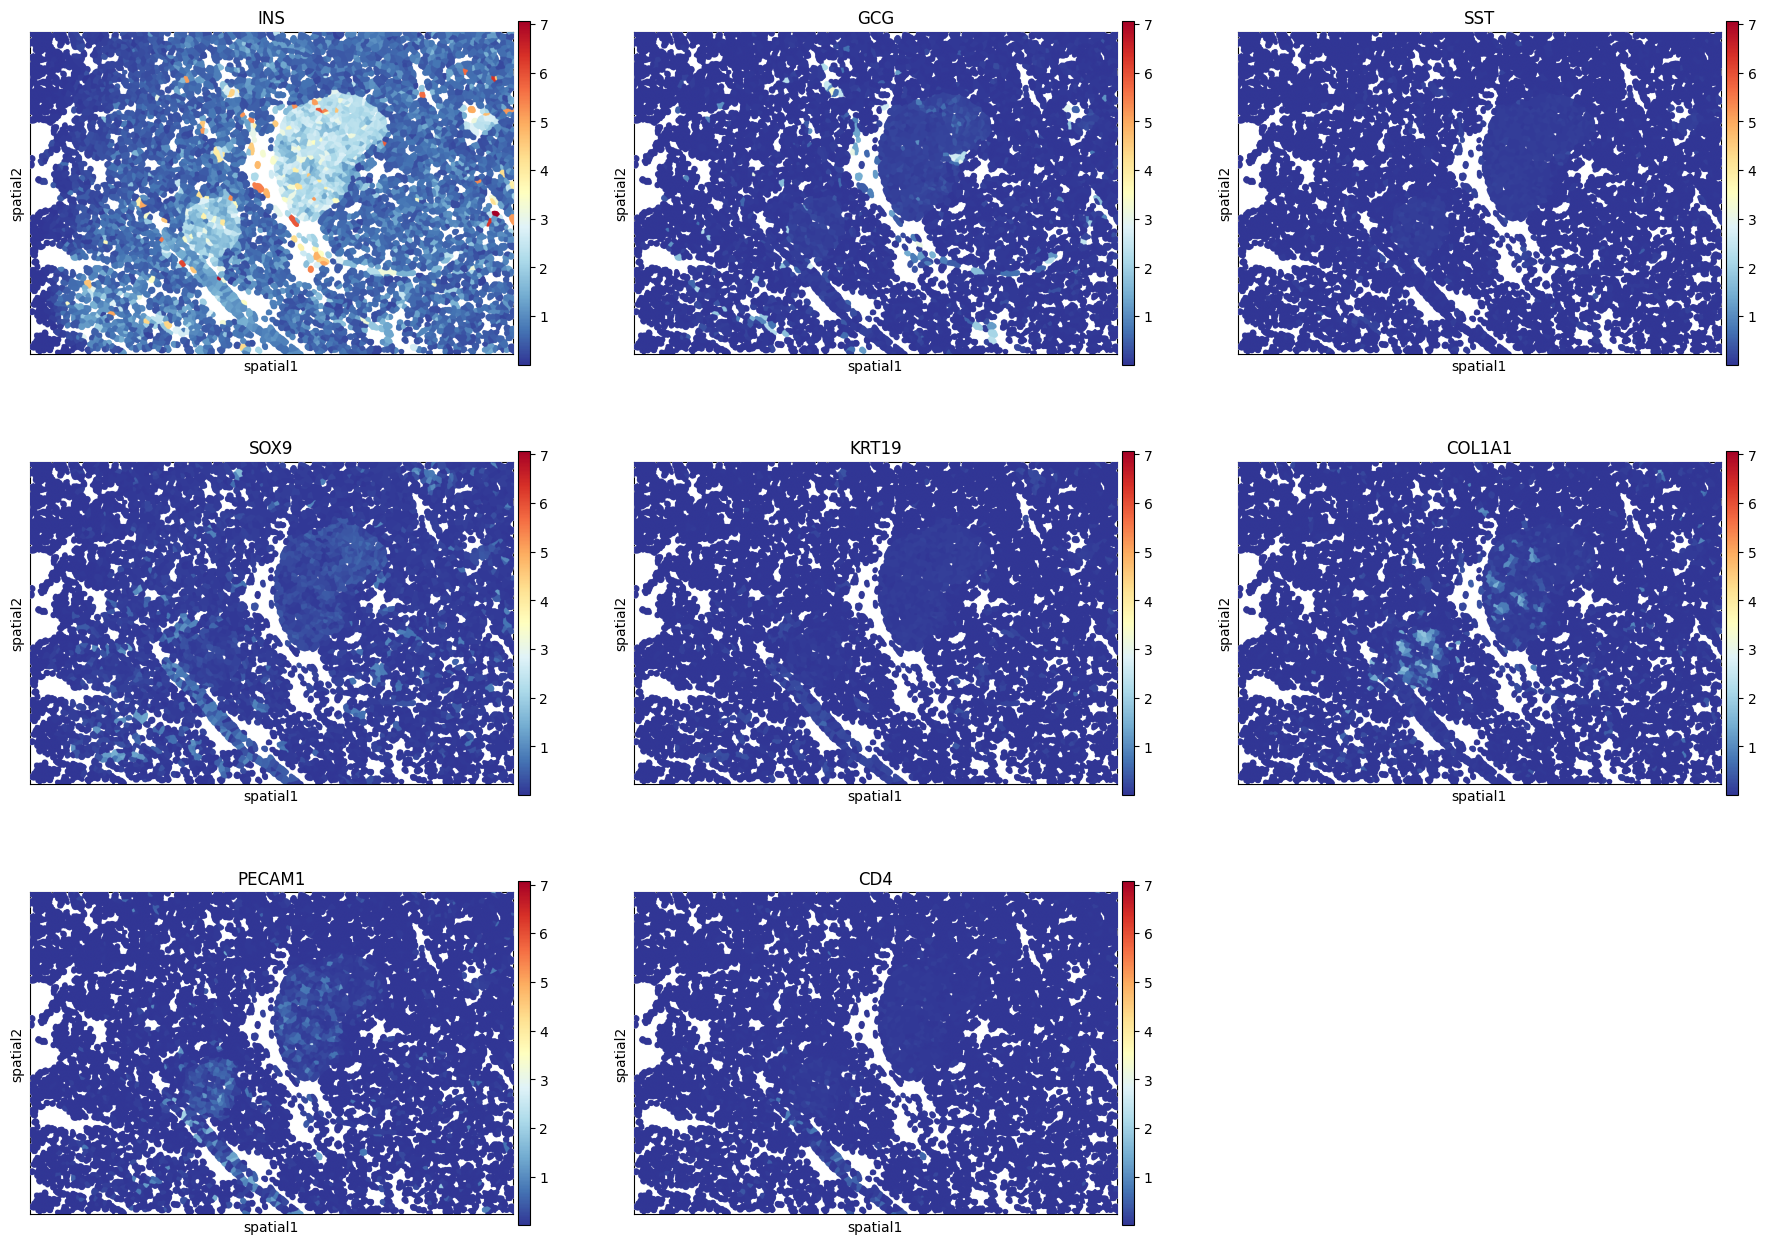

In [32]:
sq.pl.spatial_segment(adata_imputed,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

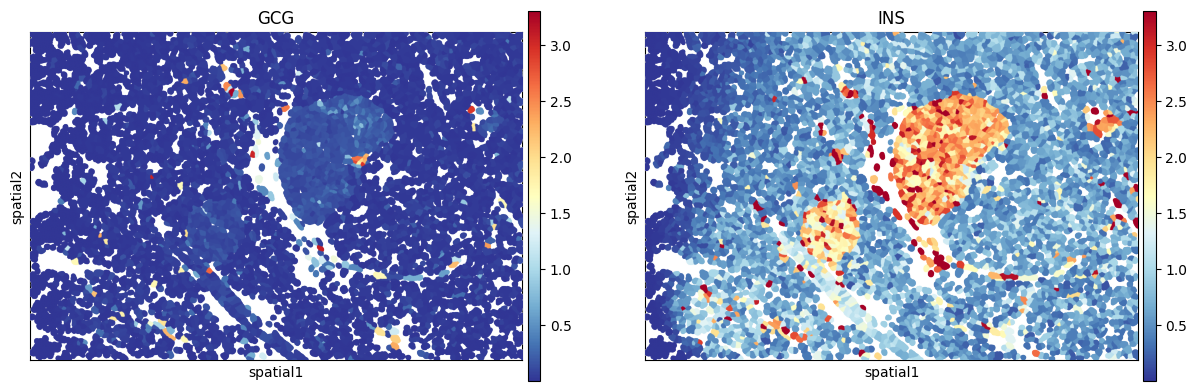

In [37]:
sq.pl.spatial_segment(adata_imputed,color=['GCG','INS'],ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [ ]:
sq.pl.spatial_segment(adata_imputed,color=['GCG','SST'],ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Plotting observed gene expression for hallmark hormone genes

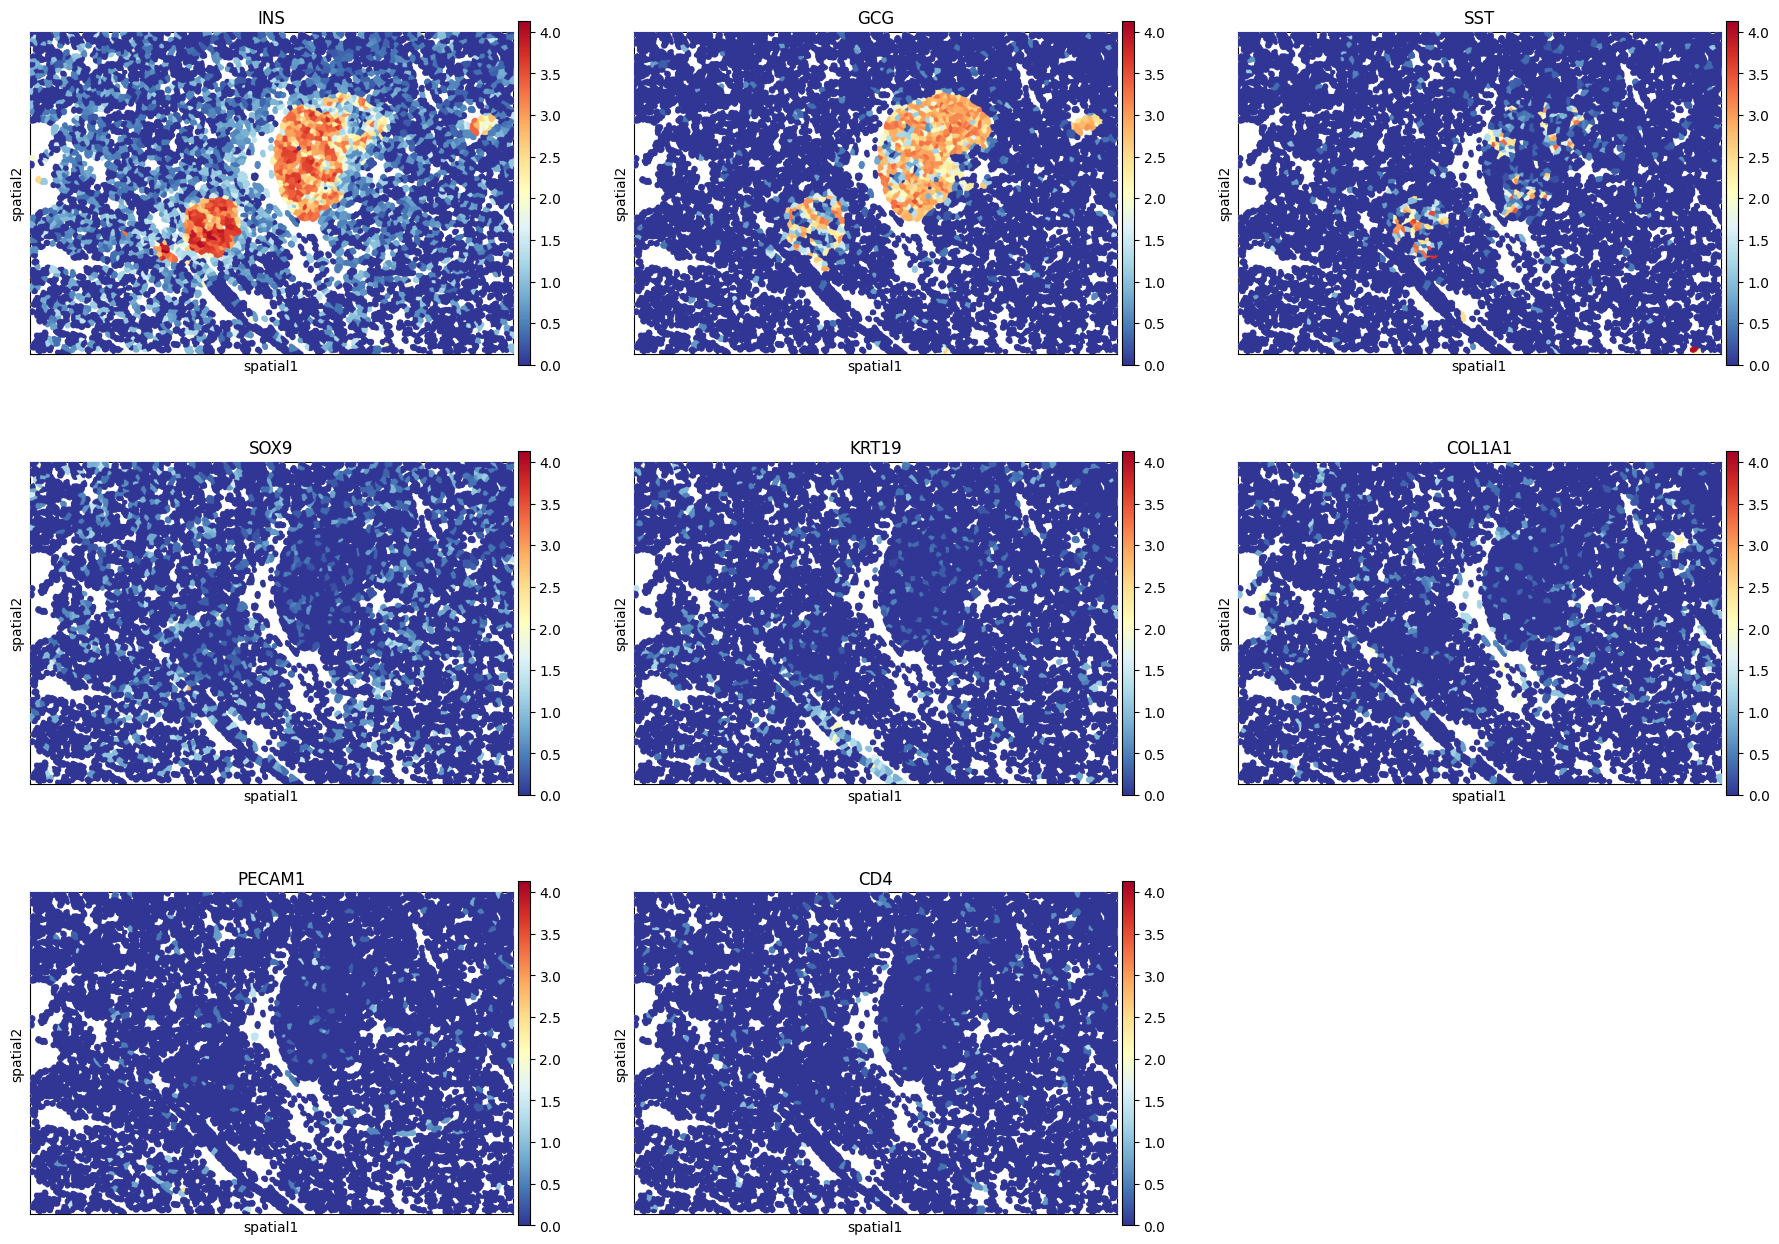

In [38]:
sq.pl.spatial_segment(adata_sp_fov_12,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

#### Annotation mapping

In [ ]:
mp[("src", "tgt")]

In [ ]:
type(adata_sc.obs.cell_type_coarse)

In [ ]:
adata_sc.obs.cell_type_coarse = adata_sc.obs.cell_type_coarse.astype("category")

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [ ]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=1.0
%env XLA_PYTHON_CLIENT_ALLOCATOR=cub

In [ ]:
start_time = time.time()

anno_map_max = mp.annotation_mapping(
    "max",
    "cell_type_coarse",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=10,
)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

In [ ]:
adata_sp_fov_12.obs["cell_type_coarse_max"] = anno_map_max["cell_type_coarse"].values
adata_sp_fov_12.obs["cell_type_coarse_max"] = adata_sp_fov_12.obs["cell_type_coarse_max"].astype("category")

In [ ]:
sc.pl.umap(adata_sc, color="cell_type_coarse")
sc.pl.umap(adata_sp_fov_12, color=["cell_type_coarse_max"])

In [ ]:
sq.pl.spatial_segment(adata_sp_fov_12,color='cell_type_coarse_max',size=5,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [ ]:
#control_markers = ['INS','GCG','SST']
adata_imputed.obs['cell_type_coarse_max'] = adata_sp_fov_12.obs['cell_type_coarse_max']

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots(1, len(markers2impute), figsize=(25, 6.8), sharey=True)

for i, marker in enumerate(markers2impute):
    # Retrieving measured counts
    measured = sc.get.obs_df(adata_sp_fov_12, [marker, "cell_type_coarse_max"])
    # Calculating measured expression levels
    measured["expression_level"] = (
        MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    )

    # Retrieving measured counts
    predicted = sc.get.obs_df(adata_imputed, [marker, "cell_type_coarse_max"])
    # Calculating predicted expression levels
    predicted["expression_level"] = (
        MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])
    )

    sns.violinplot(
        data=pd.concat(
            [measured, predicted], keys=["measured", "predicted"], names=["sample"]
        ).reset_index(),
        y="cell_type_coarse_max",
        x="expression_level",
        hue="sample",
        split=True,
        ax=ax[i],
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend()
plt.tight_layout()
plt.show()